## DYNAMIC IMPACT DROP TOWER EXPERIMENT

Postprossessing of machine data correlated with DIC and force-dicplcement curves for numerical simulation in comparison to experimental results.


In [44]:
# importing library
import numpy as np
import matplotlib.pyplot as plt 
import scipy.optimize as opt
import pandas as pd
from scipy.interpolate import interp1d

mass_MK = 15.5*10**(-3) # mass of MK in kg
mass_oct = 16.5*10**(-3) # mass of Octet in kg

### Functions

In [45]:
# loading files
def machine_file_load(filename):
    machine_data = pd.read_csv(filename, delimiter=',')
    # Extract columns as variables
    Point_ID = machine_data['Point ID'].to_numpy()
    Time = machine_data['Time'].to_numpy()
    Force = machine_data['Force'].to_numpy()
    Calculated_velocity = machine_data['Calculated velocity'].to_numpy()
    Calculated_energy = machine_data['Calculated energy'].to_numpy()
    Calculated_displacement = machine_data['Calculated displacement'].to_numpy()
    Calculated_impulse = machine_data['Calculated impulse'].to_numpy()
    # return variables 
    return Point_ID, Time, Force, Calculated_velocity, Calculated_energy, Calculated_displacement, Calculated_impulse

def dic_file_load(filename):
    dic_data = np.loadtxt(filename, skiprows=4)
    DIC_frame, DIC_displacement = dic_data[:,0], dic_data[:,1]
    return DIC_frame, DIC_displacement

def force_time_array_slized(Time, Force, start_index):
    Time = Time[start_index:]
    Force = Force[start_index:]
    return Time, Force

def frame_to_time(dic_frame_array, frame_rate):
    dic_time = dic_frame_array / frame_rate
    return dic_time

def shift_time(dic_time_array):
    shift_value = dic_time_array[0]
    return dic_time_array - shift_value

def interpolate_force_data(dic_time, machine_time, machine_force):
    interpolated_machine_force = np.interp(dic_time, machine_time, machine_force)
    return interpolated_machine_force

def find_start_index_machine_force(DIC_displacement, DIC_time_shifted, Time, Force):
    # finding max force
    max_force = np.nanmax(Force)
    #print(f'Max force: {max_force}')
    # finding max force index
    max_force_index = np.nanargmax(Force)
    time_value_max_force = Time[max_force_index]
    #print(f'Max force index: {max_force_index}')
    #print(f'Time value at max force: {time_value_max_force}')
    max_DIC_disp = np.nanmax(DIC_displacement)
    #print(f'Max DIC displacement: {max_DIC_disp}')
    max_DIC_disp_index = np.nanargmax(DIC_displacement)
    #print(f'Max DIC displacement index: {max_DIC_disp_index}')
    time_value_max_DIC_disp = DIC_time_shifted[max_DIC_disp_index]
    #print(f'Time value at max DIC displacement: {time_value_max_DIC_disp}')
    start_time_value_machine_force = time_value_max_force - time_value_max_DIC_disp
    start_index_machine_force = np.nanargmin(np.abs(Time - start_time_value_machine_force))
    #print(f'Start index for machine force: {start_index_machine_force}')
    #print(f'Time value at start index: {Time[start_index_machine_force]}')
    
    '''
    plt.plot(Time, Force, label='Machine Force')
    plt.scatter(time_value_max_force, max_force, color='red', label='Max Force')
    plt.xlabel('Time (s)')
    plt.ylabel('Force (N)')
    plt.title('Machine Force vs Time with max point')
    plt.show()

    plt.plot(DIC_time_shifted, DIC_displacement, label='DIC Displacement')
    plt.scatter(time_value_max_DIC_disp, max_DIC_disp, color='green', label='Max DIC Displacement')
    plt.xlabel('Time (s)')
    plt.ylabel('DIC Displacement (mm)')
    plt.title('DIC Displacement vs Time with max point')
    plt.show()
    '''

    return start_index_machine_force

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def plot_graph(x, y, x_label, y_label, title, label): 
    plt.plot(x, y, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()



In [46]:
#force calculation

total_mass = 24.056 # kg, m_total
impactor_mass = 0.319 # kg m_2 

def impactor_force_calculation(Force_from_machine, total_mass, impactor_mass):
    # Variable explanation
        # F_c - Contact force
        # F_p - Force from machine
        # m_1 - mass of the machine (impactor excluded)
        # m_2 - mass of the impactor
    # Mass calculation
        # m_total = m_1 + m_2
        # m_1 = m_total - m_2
    # Contact foce calculation
        # F_c = (1+(m_2/m_1)) * F_p
        
    m_2 = impactor_mass
    m_1 = total_mass - m_2
    F_p = Force_from_machine
    F_c = (1 + (m_2/m_1)) * F_p
    
    return F_c


In [47]:


def machineForce_dicDisplacement(machine_filename, dic_filename, DIC_start_frame):
    # loading machine data
    Point_ID, Time, Force, Cal_vel, Cal_energy, Cal_disp, Cal_imp = machine_file_load(machine_filename)
    
    # loading DIC data
    DIC_frame, DIC_displacement = dic_file_load(dic_filename)
    # slizing to get dic start
    DIC_start_index = np.where(DIC_frame == DIC_start_frame)[0][0]
    #print(f'DIC start index: {DIC_start_index}')
    DIC_displacement = DIC_displacement[DIC_start_index:]
    #print(f'DIC start displacement pix: {DIC_displacement[0]}')
    DIC_displacement = DIC_displacement - DIC_displacement[0] # shifting to start from 0
    #print(f'DIC start displacement pix after shift: {DIC_displacement[0]}')
    DIC_frame = DIC_frame[DIC_start_index:]
    
    # converting frame to time
    frame_rate = 75000
    DIC_time = frame_to_time(DIC_frame, frame_rate/1000) # converting to milliseconds
    
    # shifting time
    DIC_time_shifted = shift_time(DIC_time)
    
    # finding the start index for machine force
    start_index_machine_force = find_start_index_machine_force(DIC_displacement, DIC_time_shifted, Time, Force)
    
    # slicing the interpolated machine force data
    Time_slized, Force_slized = force_time_array_slized(Time, Force, start_index_machine_force)
    
    # shifting the time array to start from 0
    Time_shifted = Time_slized - Time_slized[0]
    
    # interpolating force data
    interpolated_machine_force = interpolate_force_data(DIC_time_shifted, Time_shifted, Force_slized)
    
    # defining the new array that correlates with the dic displacement
    machine_force = interpolated_machine_force

    # calculating the contact force
    total_mass = 24.056 # kg, m_total
    impactor_mass = 0.319 # kg m_2
    Contact_force = impactor_force_calculation(machine_force, total_mass, impactor_mass)

    # coverting from pix to mm
    pix_to_mm = 0.0828 # 1 pixel = 0.0842 mm
    DIC_displacement = DIC_displacement * pix_to_mm # converting from pixels to mm
    
    #slizing array at max force
    max_force = np.nanmax(Contact_force)
    max_force_index = np.nanargmax(Contact_force)
    Contact_force = Contact_force[:max_force_index+1]
    DIC_displacement = DIC_displacement[:max_force_index+1]

    smoothed_force = moving_average(Contact_force, window_size=20)
    smoothed_disp = DIC_displacement[:len(smoothed_force)]  # match array lengths

    return smoothed_force, smoothed_disp

### Import data

In [48]:
# load data 

# FU-O-dynamic-HighDynSR.txt
data_Oct_Dyn_High = np.loadtxt('FU-O-dynamic-HighDynSR.txt', skiprows=3)
disp_Oct_Dyn_High, force_Oct_Dyn_High = data_Oct_Dyn_High[:,0], data_Oct_Dyn_High[:,1]

# FU-O-dynamic-LowDynSR.txt
data_Oct_Dyn_Low = np.loadtxt('FU-O-dynamic-LowDynSR.txt', skiprows=3)
disp_Oct_Dyn_Low, force_Oct_Dyn_Low = data_Oct_Dyn_Low[:,0], data_Oct_Dyn_Low[:,1]

#FU-MK-dyn-high.txt
data_MK_dyn_high = np.loadtxt('FU-MK-dyn-high.txt', skiprows=3)
disp_MK_dyn_high, force_MK_dyn_high = data_MK_dyn_high[:,0], data_MK_dyn_high[:,1]

#FU-MK-dyn-low.txt
data_MK_dyn_low = np.loadtxt('FU-MK-dyn-low.txt', skiprows=3)
disp_MK_dyn_low, force_MK_dyn_low = data_MK_dyn_low[:,0], data_MK_dyn_low[:,1]



In [49]:
textStr = 18
textStrTitle = 26
numbStr = 18
linewidthStr = 0.75
textStr = 20
textStrTitle = 30
numbStr = 18

DO1_start_frame = 1001
DO2_start_frame = 1054
DO3_start_frame = 1049
DO4_start_frame = 1782
DO5_start_frame = 1658
DO6_start_frame = 2379

DK1_start_frame = 1133
DK2_start_frame = 1135 #1174
DK3_start_frame = 1172
DK4_start_frame = 1934 #1913
#no DK5 data 
DK6_start_frame = 817 #825
DK7_start_frame = 1714

xmax = 30
ymax = 600

machine_force_DK1, DIC_disp_DK1 = machineForce_dicDisplacement('DK1_machine_data.csv', 'DK1_frame_disp.txt', DK1_start_frame)
machine_force_DK2, DIC_disp_DK2 = machineForce_dicDisplacement('DK2_machine_data.csv', 'DK2_frame_disp.txt', DK2_start_frame)
machine_force_DK3, DIC_disp_DK3 = machineForce_dicDisplacement('DK3_machine_data.csv', 'DK3_frame_disp.txt', DK3_start_frame)
machine_force_DK4, DIC_disp_DK4 = machineForce_dicDisplacement('DK4_machine_data.csv', 'DK4_frame_disp.txt', DK4_start_frame)
machine_force_DK6, DIC_disp_DK6 = machineForce_dicDisplacement('DK6_machine_data.csv', 'DK6_frame_disp.txt', DK6_start_frame)
machine_force_DK7, DIC_disp_DK7 = machineForce_dicDisplacement('DK7_machine_data.csv', 'DK7_frame_disp_new_txt_3.txt', DK7_start_frame)
machine_force_DO1, DIC_disp_DO1 = machineForce_dicDisplacement('DO1_machine_data.csv', 'DO1_frame_disp.txt', DO1_start_frame)
machine_force_DO2, DIC_disp_DO2 = machineForce_dicDisplacement('DO2_machine_data.csv', 'DO2_frame_disp.txt', DO2_start_frame)
machine_force_DO3, DIC_disp_DO3 = machineForce_dicDisplacement('DO3_machine_data.csv', 'DO3_frame_disp.txt', DO3_start_frame)
machine_force_DO4, DIC_disp_DO4 = machineForce_dicDisplacement('DO4_machine_data.csv', 'DO4_frame_disp.txt', DO4_start_frame)
machine_force_DO5, DIC_disp_DO5 = machineForce_dicDisplacement('DO5_machine_data.csv', 'DO5_frame_disp.txt', DO5_start_frame)
machine_force_DO6, DIC_disp_DO6 = machineForce_dicDisplacement('DO6_machine_data.csv', 'DO6_frame_disp.txt', DO6_start_frame)


### EXPERIMENTAL PLOTS

#### Test data

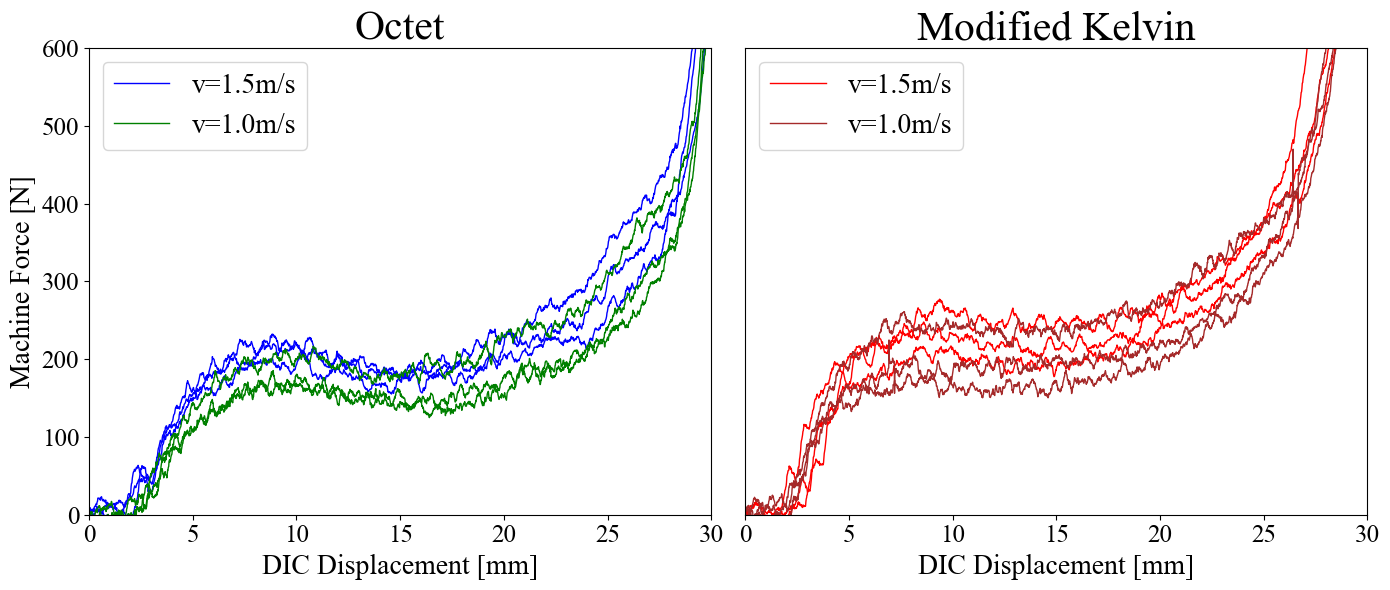

In [50]:
# Settings
textStr = 20
textStrTitle = 30
numbStr = 18
xmax = 30
ymax = 600
linewidthStr = 1

plt.rcParams["font.family"] = "Times New Roman"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left Plot: Octet ---
ax1.plot(DIC_disp_DO1, machine_force_DO1, label='v=1.5m/s', color='blue', linewidth=linewidthStr)
ax1.plot(DIC_disp_DO2, machine_force_DO2, color='blue', linewidth=linewidthStr)
ax1.plot(DIC_disp_DO3, machine_force_DO3, color='blue', linewidth=linewidthStr)
ax1.plot(DIC_disp_DO4, machine_force_DO4, label='v=1.0m/s', color='green', linewidth=linewidthStr)
ax1.plot(DIC_disp_DO5, machine_force_DO5, color='green', linewidth=linewidthStr)
ax1.plot(DIC_disp_DO6, machine_force_DO6, color='green', linewidth=linewidthStr)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax1.set_xlabel('DIC Displacement [mm]', fontsize=textStr)
ax1.set_ylabel('Machine Force [N]', fontsize=textStr)
ax1.set_title('Octet', fontsize=textStrTitle)
ax1.tick_params(axis='both', labelsize=numbStr)
ax1.legend(fontsize=textStr)

# --- Right Plot: Modified Kelvin ---
ax2.plot(DIC_disp_DK1, machine_force_DK1, label='v=1.5m/s', color='red', linewidth=linewidthStr)
ax2.plot(DIC_disp_DK2, machine_force_DK2, color='red', linewidth=linewidthStr)
ax2.plot(DIC_disp_DK3, machine_force_DK3, color='red', linewidth=linewidthStr)
ax2.plot(DIC_disp_DK4, machine_force_DK4, label='v=1.0m/s', color='brown', linewidth=linewidthStr)
ax2.plot(DIC_disp_DK6, machine_force_DK6, color='brown', linewidth=linewidthStr)
ax2.plot(DIC_disp_DK7, machine_force_DK7, color='brown', linewidth=linewidthStr)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax2.set_xlabel('DIC Displacement [mm]', fontsize=textStr)
ax2.set_title('Modified Kelvin', fontsize=textStrTitle)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.tick_params(axis='x', labelsize=numbStr)
ax2.set_ylabel("")
ax2.legend(fontsize=textStr)

plt.tight_layout()
plt.show()


#### Averaged force test data

In [51]:
# --- Octet v=1.0m/s Average Curve ---
# 1. Define a common displacement grid
octet_1ms_disp_min = max(np.min(DIC_disp_DO4), np.min(DIC_disp_DO5), np.min(DIC_disp_DO6))
octet_1ms_disp_max = min(np.max(DIC_disp_DO4), np.max(DIC_disp_DO5), np.max(DIC_disp_DO6))
octet_1ms_common_disp = np.linspace(octet_1ms_disp_min, octet_1ms_disp_max, 500)

# 2. Interpolate forces onto the common grid
octet_1ms_force4_interp = np.interp(octet_1ms_common_disp, DIC_disp_DO4, machine_force_DO4)
octet_1ms_force5_interp = np.interp(octet_1ms_common_disp, DIC_disp_DO5, machine_force_DO5)
octet_1ms_force6_interp = np.interp(octet_1ms_common_disp, DIC_disp_DO6, machine_force_DO6)

# 3. Average the forces
octet_1ms_force_avg = np.nanmean([octet_1ms_force4_interp, octet_1ms_force5_interp, octet_1ms_force6_interp], axis=0)

# --- Octet v=1.5m/s Average Curve ---
octet_15ms_disp_min = max(np.min(DIC_disp_DO1), np.min(DIC_disp_DO2), np.min(DIC_disp_DO3))
octet_15ms_disp_max = min(np.max(DIC_disp_DO1), np.max(DIC_disp_DO2), np.max(DIC_disp_DO3))
octet_15ms_common_disp = np.linspace(octet_15ms_disp_min, octet_15ms_disp_max, 500)

octet_15ms_force1_interp = np.interp(octet_15ms_common_disp, DIC_disp_DO1, machine_force_DO1)
octet_15ms_force2_interp = np.interp(octet_15ms_common_disp, DIC_disp_DO2, machine_force_DO2)
octet_15ms_force3_interp = np.interp(octet_15ms_common_disp, DIC_disp_DO3, machine_force_DO3)

octet_15ms_force_avg = np.nanmean([octet_15ms_force1_interp, octet_15ms_force2_interp, octet_15ms_force3_interp], axis=0)


# --- Modified Kelvin v=1.5m/s Average Curve ---
mk_15ms_disp_min = max(np.min(DIC_disp_DK1), np.min(DIC_disp_DK2), np.min(DIC_disp_DK3))
mk_15ms_disp_max = min(np.max(DIC_disp_DK1), np.max(DIC_disp_DK2), np.max(DIC_disp_DK3))
mk_15ms_common_disp = np.linspace(mk_15ms_disp_min, mk_15ms_disp_max, 500)

mk_15ms_force1_interp = np.interp(mk_15ms_common_disp, DIC_disp_DK1, machine_force_DK1)
mk_15ms_force2_interp = np.interp(mk_15ms_common_disp, DIC_disp_DK2, machine_force_DK2)
mk_15ms_force3_interp = np.interp(mk_15ms_common_disp, DIC_disp_DK3, machine_force_DK3)

mk_15ms_force_avg = np.nanmean([mk_15ms_force1_interp, mk_15ms_force2_interp, mk_15ms_force3_interp], axis=0)

# --- Modified Kelvin v=1.0m/s Average Curve ---
mk_10ms_disp_min = max(np.min(DIC_disp_DK4), np.min(DIC_disp_DK6), np.min(DIC_disp_DK7))
mk_10ms_disp_max = min(np.max(DIC_disp_DK4), np.max(DIC_disp_DK6), np.max(DIC_disp_DK7))
mk_10ms_common_disp = np.linspace(mk_10ms_disp_min, mk_10ms_disp_max, 500)

mk_10ms_force4_interp = np.interp(mk_10ms_common_disp, DIC_disp_DK4, machine_force_DK4)
mk_10ms_force6_interp = np.interp(mk_10ms_common_disp, DIC_disp_DK6, machine_force_DK6)
mk_10ms_force7_interp = np.interp(mk_10ms_common_disp, DIC_disp_DK7, machine_force_DK7)

mk_10ms_force_avg = np.nanmean([mk_10ms_force4_interp, mk_10ms_force6_interp, mk_10ms_force7_interp], axis=0)


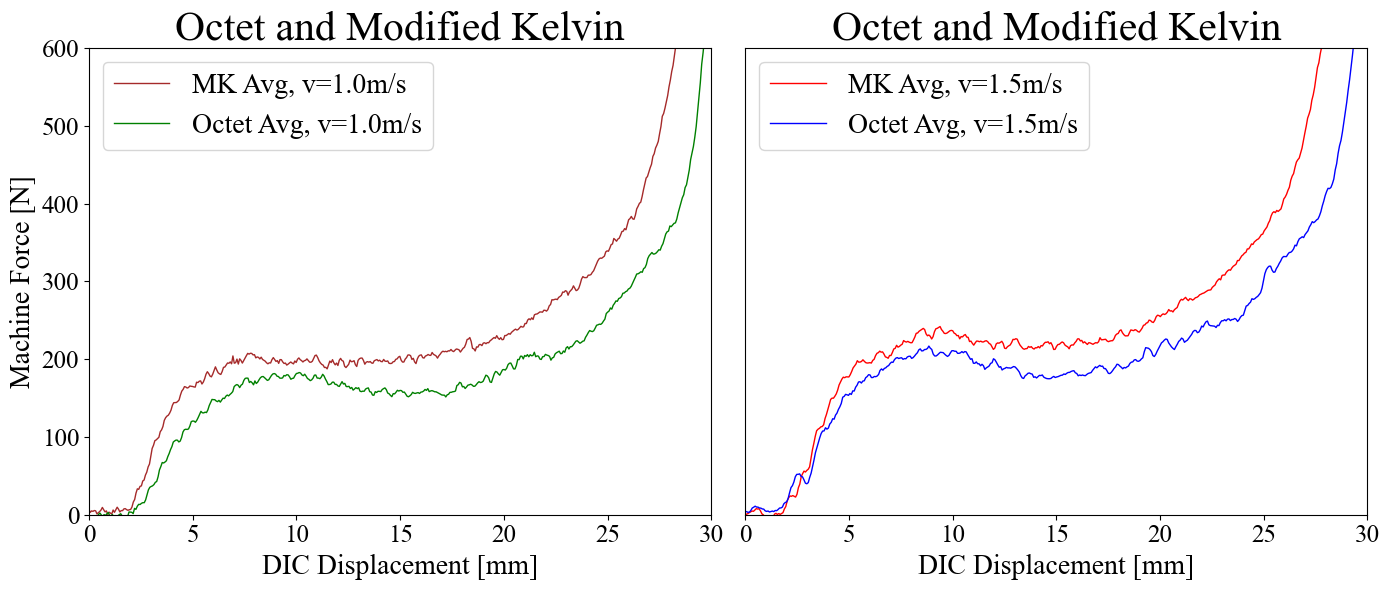

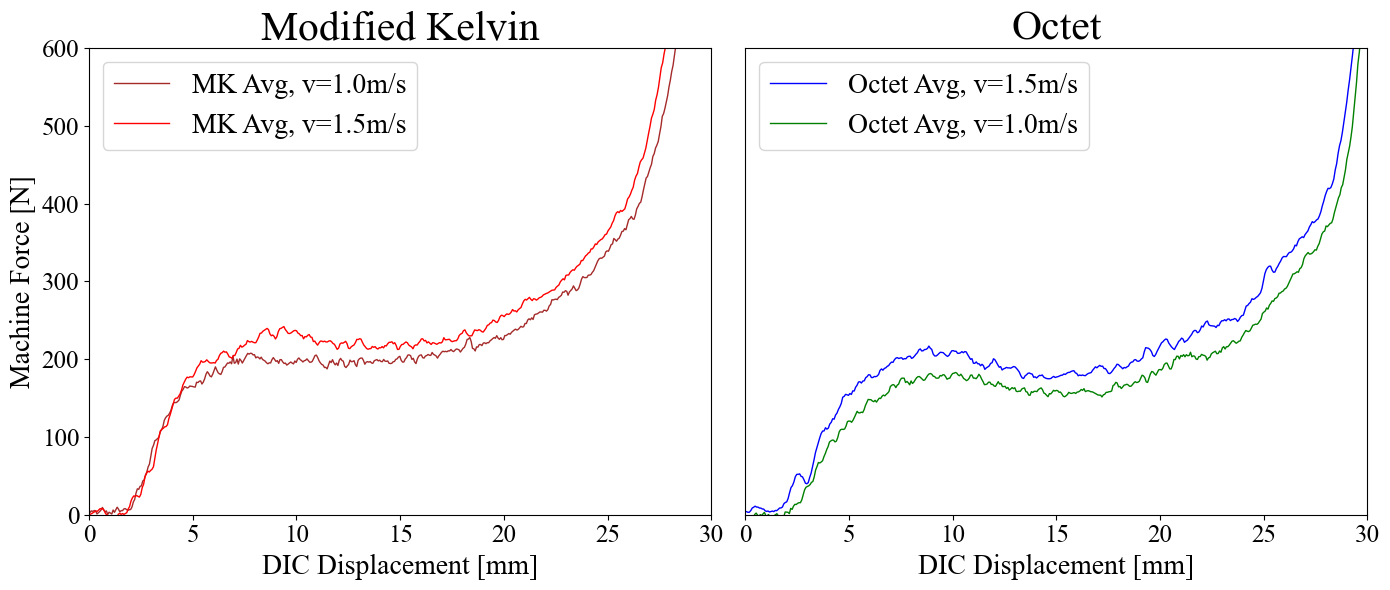

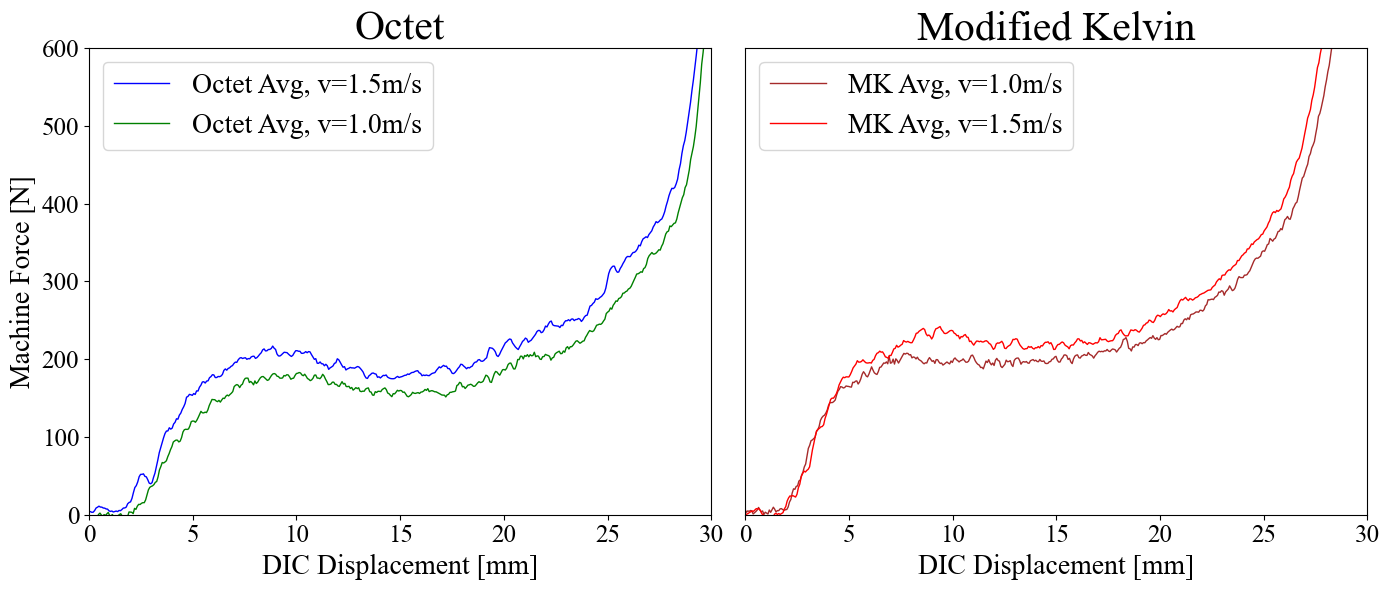

In [52]:
textStr = 20
textStrTitle = 30
numbStr = 18
xmax = 30
ymax = 600
linewidthStr = 1

plt.rcParams["font.family"] = "Times New Roman"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left Plot: 1.0 m/s ---
ax1.plot(mk_10ms_common_disp, mk_10ms_force_avg, label='MK Avg, v=1.0m/s', color='brown', linewidth=linewidthStr)
ax1.plot(octet_1ms_common_disp, octet_1ms_force_avg, label='Octet Avg, v=1.0m/s', color='green', linewidth=linewidthStr)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax1.set_xlabel('DIC Displacement [mm]', fontsize=textStr)
ax1.set_ylabel('Machine Force [N]', fontsize=textStr)
ax1.set_title('Octet and Modified Kelvin', fontsize=textStrTitle)
ax1.tick_params(axis='both', labelsize=numbStr)
ax1.legend(fontsize=textStr)

# --- Right Plot: 1.5 m/s ---
ax2.plot(mk_15ms_common_disp, mk_15ms_force_avg, label='MK Avg, v=1.5m/s', color='red', linewidth=linewidthStr)
ax2.plot(octet_15ms_common_disp, octet_15ms_force_avg, label='Octet Avg, v=1.5m/s', color='blue', linewidth=linewidthStr)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax2.set_xlabel('DIC Displacement [mm]', fontsize=textStr)
ax2.set_title('Octet and Modified Kelvin', fontsize=textStrTitle)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.tick_params(axis='x', labelsize=numbStr)
ax2.set_ylabel("")
ax2.legend(fontsize=textStr)

plt.tight_layout()
plt.show()

plt.rcParams["font.family"] = "Times New Roman"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left Plot: 1.0 m/s ---
ax1.plot(mk_10ms_common_disp, mk_10ms_force_avg, label='MK Avg, v=1.0m/s', color='brown', linewidth=linewidthStr)
ax1.plot(mk_15ms_common_disp, mk_15ms_force_avg, label='MK Avg, v=1.5m/s', color='red', linewidth=linewidthStr)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax1.set_xlabel('DIC Displacement [mm]', fontsize=textStr)
ax1.set_ylabel('Machine Force [N]', fontsize=textStr)
ax1.set_title('Modified Kelvin', fontsize=textStrTitle)
ax1.tick_params(axis='both', labelsize=numbStr)
ax1.legend(fontsize=textStr)

# --- Right Plot: 1.5 m/s ---
ax2.plot(octet_15ms_common_disp, octet_15ms_force_avg, label='Octet Avg, v=1.5m/s', color='blue', linewidth=linewidthStr)
ax2.plot(octet_1ms_common_disp, octet_1ms_force_avg, label='Octet Avg, v=1.0m/s', color='green', linewidth=linewidthStr)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax2.set_xlabel('DIC Displacement [mm]', fontsize=textStr)
ax2.set_title('Octet', fontsize=textStrTitle)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.tick_params(axis='x', labelsize=numbStr)
ax2.set_ylabel("")
ax2.legend(fontsize=textStr)

plt.tight_layout()
plt.show()

plt.rcParams["font.family"] = "Times New Roman"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left Plot: Octet ---
ax1.plot(octet_15ms_common_disp, octet_15ms_force_avg, label='Octet Avg, v=1.5m/s', color='blue', linewidth=linewidthStr)
ax1.plot(octet_1ms_common_disp, octet_1ms_force_avg, label='Octet Avg, v=1.0m/s', color='green', linewidth=linewidthStr)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax1.set_xlabel('DIC Displacement [mm]', fontsize=textStr)
ax1.set_ylabel('Machine Force [N]', fontsize=textStr)
ax1.set_title('Octet', fontsize=textStrTitle)
ax1.tick_params(axis='both', labelsize=numbStr)
ax1.legend(fontsize=textStr)

# --- Right Plot: Modified Kelvin ---
ax2.plot(mk_10ms_common_disp, mk_10ms_force_avg, label='MK Avg, v=1.0m/s', color='brown', linewidth=linewidthStr)
ax2.plot(mk_15ms_common_disp, mk_15ms_force_avg, label='MK Avg, v=1.5m/s', color='red', linewidth=linewidthStr)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax2.set_xlabel('DIC Displacement [mm]', fontsize=textStr)
ax2.set_title('Modified Kelvin', fontsize=textStrTitle)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.tick_params(axis='x', labelsize=numbStr)
ax2.set_ylabel("")
ax2.legend(fontsize=textStr)

plt.tight_layout()
plt.show()

### SIMULATION AND EXPERIMENT PLOTS


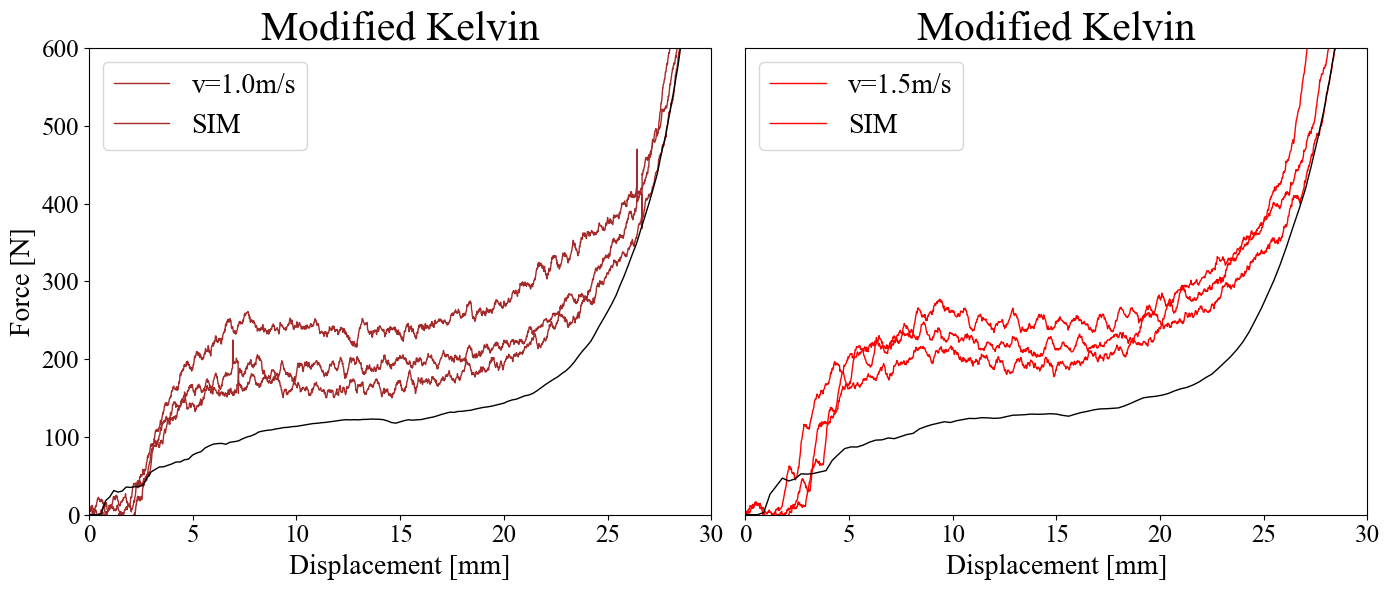

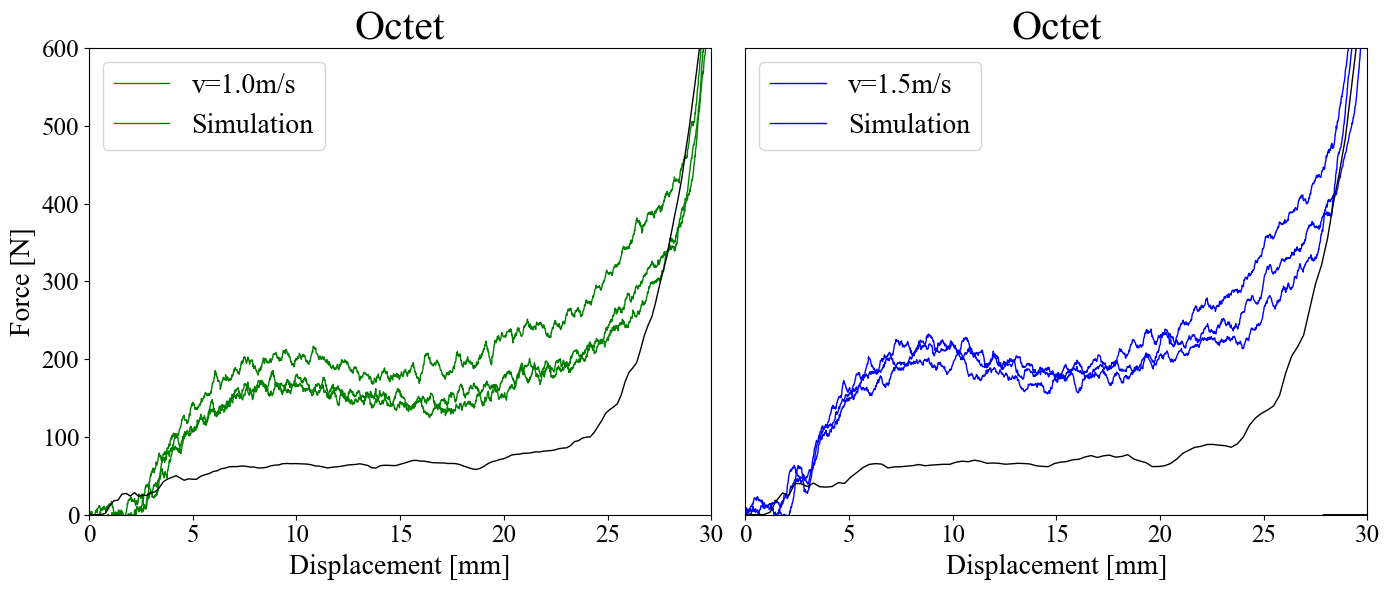

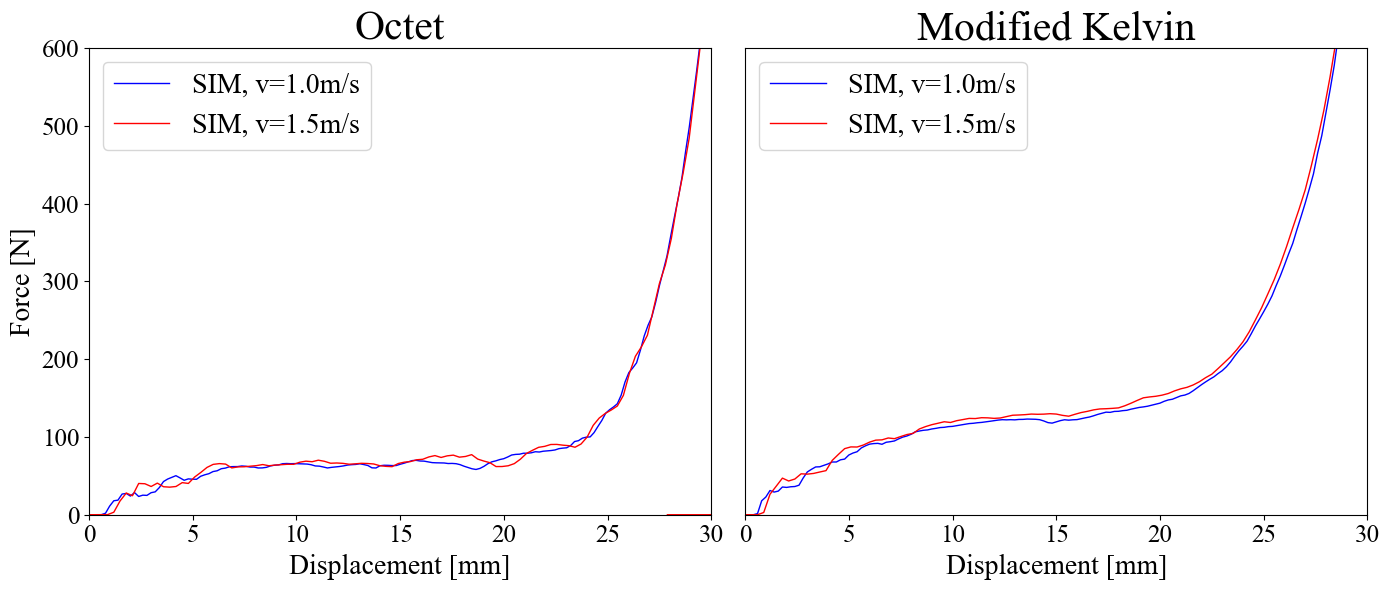

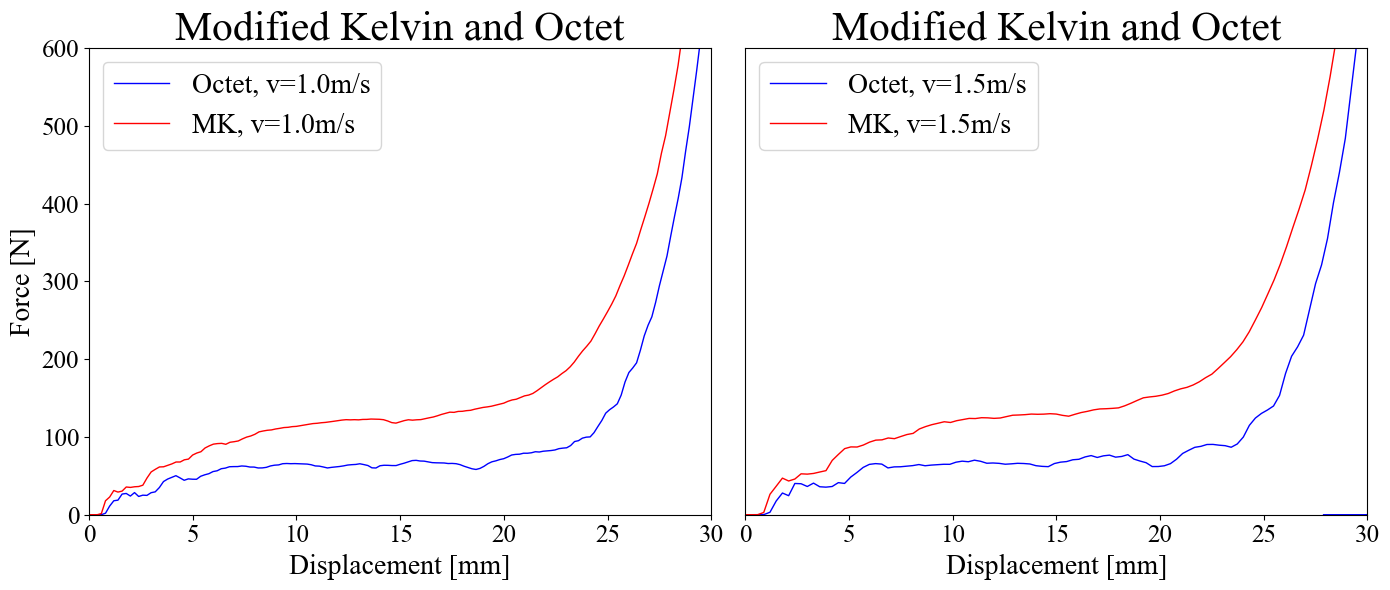

In [53]:
import matplotlib.pyplot as plt

# Settings
textStr = 20
textStrTitle = 30
numbStr = 18
xmax = 30
ymax = 600
linewidthStr = 1

plt.rcParams["font.family"] = "Times New Roman"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left Plot: Modified Kelvin Low ---
ax1.plot(DIC_disp_DK4, machine_force_DK4, color='brown', linewidth=linewidthStr)
ax1.plot(DIC_disp_DK6, machine_force_DK6, color='brown', linewidth=linewidthStr)
ax1.plot(DIC_disp_DK7, machine_force_DK7, color='brown', linewidth=linewidthStr)
ax1.plot(disp_MK_dyn_low, force_MK_dyn_low, label='SIM', color='black', linewidth=linewidthStr)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax1.set_xlabel('Displacement [mm]', fontsize=textStr)
ax1.set_ylabel('Force [N]', fontsize=textStr)
ax1.set_title('Modified Kelvin', fontsize=textStrTitle)
ax1.tick_params(axis='both', labelsize=numbStr)
ax1.legend(['v=1.0m/s', 'SIM'], fontsize=textStr)

# --- Right Plot: Modified Kelvin High ---
ax2.plot(DIC_disp_DK1, machine_force_DK1, color='red', linewidth=linewidthStr)
ax2.plot(DIC_disp_DK2, machine_force_DK2, color='red', linewidth=linewidthStr)
ax2.plot(DIC_disp_DK3, machine_force_DK3, color='red', linewidth=linewidthStr)
ax2.plot(disp_MK_dyn_high, force_MK_dyn_high, label='SIM', color='black', linewidth=linewidthStr)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax2.set_xlabel('Displacement [mm]', fontsize=textStr)
ax2.set_title('Modified Kelvin', fontsize=textStrTitle)
ax2.tick_params(axis='y', left=False, labelleft=False)  # <- hide y-axis ticks and labels
ax2.tick_params(axis='x', labelsize=numbStr)
ax2.set_ylabel("")  # Remove y-axis label
ax2.legend(['v=1.5m/s', 'SIM'], fontsize=textStr)

plt.tight_layout()
plt.show()


plt.rcParams["font.family"] = "Times New Roman"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left Plot: Octet Low ---
ax1.plot(DIC_disp_DO4, machine_force_DO4, color='green', linewidth=linewidthStr)
ax1.plot(DIC_disp_DO5, machine_force_DO5, color='green', linewidth=linewidthStr)
ax1.plot(DIC_disp_DO6, machine_force_DO6, color='green', linewidth=linewidthStr)
ax1.plot(disp_Oct_Dyn_Low, force_Oct_Dyn_Low, label='Simulation', color='black', linewidth=linewidthStr)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax1.set_xlabel('Displacement [mm]', fontsize=textStr)
ax1.set_ylabel('Force [N]', fontsize=textStr)
ax1.set_title('Octet', fontsize=textStrTitle)
ax1.tick_params(axis='both', labelsize=numbStr)
ax1.legend(['v=1.0m/s', 'Simulation'], fontsize=textStr)

# --- Right Plot: Octet High ---
ax2.plot(DIC_disp_DO1, machine_force_DO1, color='blue', linewidth=linewidthStr)
ax2.plot(DIC_disp_DO2, machine_force_DO2, color='blue', linewidth=linewidthStr)
ax2.plot(DIC_disp_DO3, machine_force_DO3, color='blue', linewidth=linewidthStr)
ax2.plot(disp_Oct_Dyn_High, force_Oct_Dyn_High, label='Simulation', color='black', linewidth=linewidthStr)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax2.set_xlabel('Displacement [mm]', fontsize=textStr)
ax2.set_title('Octet', fontsize=textStrTitle)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.tick_params(axis='x', labelsize=numbStr)
ax2.set_ylabel("")
ax2.legend(['v=1.5m/s', 'Simulation'], fontsize=textStr)

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Settings
textStr = 20
textStrTitle = 30
numbStr = 18
xmax = 30
ymax = 600
linewidthStr = 1

plt.rcParams["font.family"] = "Times New Roman"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left Plot: Octet ---
ax1.plot(disp_Oct_Dyn_Low, force_Oct_Dyn_Low, label='SIM, v=1.0m/s', color='blue', linewidth=linewidthStr)
ax1.plot(disp_Oct_Dyn_High, force_Oct_Dyn_High, label='SIM, v=1.5m/s', color='red', linewidth=linewidthStr)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax1.set_xlabel('Displacement [mm]', fontsize=textStr)
ax1.set_ylabel('Force [N]', fontsize=textStr)
ax1.set_title('Octet', fontsize=textStrTitle)
ax1.tick_params(axis='both', labelsize=numbStr)
ax1.legend(fontsize=textStr)

# --- Right Plot: Modified Kelvin ---
ax2.plot(disp_MK_dyn_low, force_MK_dyn_low, label='SIM, v=1.0m/s', color='blue', linewidth=linewidthStr)
ax2.plot(disp_MK_dyn_high, force_MK_dyn_high, label='SIM, v=1.5m/s', color='red', linewidth=linewidthStr)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax2.set_xlabel('Displacement [mm]', fontsize=textStr)
ax2.set_title('Modified Kelvin', fontsize=textStrTitle)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.tick_params(axis='x', labelsize=numbStr)
ax2.set_ylabel("")
ax2.legend(fontsize=textStr)

plt.tight_layout()
plt.show()


plt.rcParams["font.family"] = "Times New Roman"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Left Plot: v = 1.0 m/s ---
ax1.plot(disp_Oct_Dyn_Low, force_Oct_Dyn_Low, label='Octet, v=1.0m/s', color='blue', linewidth=linewidthStr)
ax1.plot(disp_MK_dyn_low, force_MK_dyn_low, label='MK, v=1.0m/s', color='red', linewidth=linewidthStr)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax1.set_xlabel('Displacement [mm]', fontsize=textStr)
ax1.set_ylabel('Force [N]', fontsize=textStr)
ax1.set_title('Modified Kelvin and Octet', fontsize=textStrTitle)
ax1.tick_params(axis='both', labelsize=numbStr)
ax1.legend(fontsize=textStr)

# --- Right Plot: v = 1.5 m/s ---
ax2.plot(disp_Oct_Dyn_High, force_Oct_Dyn_High, label='Octet, v=1.5m/s', color='blue', linewidth=linewidthStr)
ax2.plot(disp_MK_dyn_high, force_MK_dyn_high, label='MK, v=1.5m/s', color='red', linewidth=linewidthStr)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax2.set_xlabel('Displacement [mm]', fontsize=textStr)
ax2.set_title('Modified Kelvin and Octet', fontsize=textStrTitle)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.tick_params(axis='x', labelsize=numbStr)
ax2.set_ylabel("")
ax2.legend(fontsize=textStr)

plt.tight_layout()
plt.show()
